# Classification to identify price-related tweets

**Objective**

We use the embeddings computed for each tweet and the labels added manually to train a random forest model to detect tweets whether a tweet is related to prices matter.

## Setup

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

import pickle as pkl

from rich.table import Table 
from rich.console import Console

In [58]:
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA

from sklearn.model_selection import (
    train_test_split, 
    cross_val_score, 
    GridSearchCV
)

from sklearn.pipeline import Pipeline

from sklearn.dummy import DummyClassifier 
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC

from sklearn.metrics import (
    balanced_accuracy_score, 
    make_scorer,
    confusion_matrix, 
    ConfusionMatrixDisplay
)

In [3]:
from xgboost import XGBClassifier

In [4]:
import sqlalchemy
from optuna import Trial, create_study

In [5]:
from multiprocessing import cpu_count

In [6]:
CPU_COUNT = cpu_count()
CPU_COUNT

8

## Data

### Load annotated dataset and embeddings

In [16]:
df_annotated = pd.read_csv("../backup/data/df_annotated.csv")

In [8]:
df_annotated.head()

,timestamp,text,emojis,retweets,likes,comments,lexical_field,text_emojis,label
0,2020-01-01,le tout vendu à des prix \n«défiant toute conc...,NaN,NaN,NaN,NaN,cheap,NaN,NaN
1,2020-01-01,Pour ceux qui veulent allier l'utile à l'agréa...,🛑 🛑,NaN,NaN,NaN,cheap,Pour ceux qui veulent allier l'utile à l'agréa...,NaN
2,2020-01-02,"Nouvelle perspective: BARAKA BUSINESS SARL, ne...",NaN,3.0,NaN,NaN,cheap,NaN,not_about_prices
3,2020-01-02,J'ai du mal à savoir si #Cirelli a reçu la Leg...,NaN,3.0,1.0,NaN,cheap,NaN,NaN
4,2020-01-06,Un iPhone pas cher ? C’est maintenant possible...,⭐ 😉,284.0,69.0,36.0,cheap,Un iPhone pas cher ? C’est maintenant possible...,NaN


In [9]:
df_annotated["label"].value_counts()

not_about_prices    684
inflation           302
desinflation         14
other                11
deflation             5
stability             2
Name: label, dtype: int64

In [10]:
def is_on_topic(label: str) -> float: 
    """Description. 
    Return 1 if label is about prices, 0 is not about prices and nan if no label."""

    if pd.isna(label): 
        return float("nan")
    elif label == "not_about_prices": 
        return 0
    else: 
        return 1

In [17]:
df_annotated["on_topic"] = df_annotated["label"].apply(is_on_topic)

In [12]:
embeddings = np.load("../backup/data/embeddings_french.npy")

In [13]:
assert embeddings.shape[0] == df_annotated.shape[0]

### Train/test split 

In [18]:
annotated_idxs = df_annotated.loc[df_annotated["on_topic"].notna(), :].index.values.tolist()

In [19]:
df_annotated["on_topic"][annotated_idxs].value_counts()

0.0    684
1.0    334
Name: on_topic, dtype: int64

In [20]:
X, y = embeddings, df_annotated["on_topic"].values

X_train, y_train = X[annotated_idxs, :], y[annotated_idxs]
X_test = np.delete(X, annotated_idxs, axis=0)

In [21]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.1)

### Principal Component Analysis (PCA)

PCA is used to decompose a multivariate dataset in a set of successive orthogonal components that explain a maximum amount of the variance. The objective is to reduce the dimension of the embeddings so as to remove as much noise as possible and only keep general patterns.

In [59]:
# amount of variance that needs to be explained
min_exp_var = .95

pca = PCA(n_components=min_exp_var, svd_solver="full")
pca.fit(X_train)

PCA(n_components=0.95, svd_solver='full')

In [60]:
X_train_pca = pca.transform(X_train)
X_val_pca = pca.transform(X_val)

In [67]:
print(f"Original embeddings" dimension: {X_train.shape[1]}")
print(f"Reduced embeddings" dimension: {X_train_pca.shape[1] }")

Original embeddings' dimension: 1024
Reduced embeddings' dimension: 370


## Models

**Balanced accuracy**

Balanced accuracy in binary and multi-class classification is defined as the average of recall obtained on each class. Let us note $y^{"}_i$ the label of the $i$-th sample in the test set and $\tilde{y}^{"}_i$ the predicted label. The test set contains $m$ samples and the target variable consists of $J$ classes. Formally, recall on class $j$ is defined as the following ratio: 
$$
\text{recall}_j = \frac{\sum_{i}^m \pmb{1}_{y^{"}_i = \tilde{y}^{"}_i} \times \pmb{1}_{y^{"}_i = j}}{\sum_{i}^m \pmb{1}_{\tilde{y}^{"}_i = j}} 
$$

Thus, the balanced accuracy score can be expressed as:
$$
\text{bacc} = \frac{1}{j}\sum_{j=1}^J \text{recall}_j = \frac{1}{j}\sum_{j=1}^J \frac{\sum_{i}^m \pmb{1}_{y^{"}_i = \tilde{y}^{"}_i} \times \pmb{1}_{y^{"}_i = j}}{\sum_{i}^m \pmb{1}_{\tilde{y}^{"}_i = j}}
$$

In [22]:
balanced_scorer = make_scorer(balanced_accuracy_score)

In [61]:
# instantiate list to save model results

results = []

In [24]:
from typing import List, Dict, Union

def get_model_dict(model_name: str, params: Union[List, Dict], train_scores: List, val_score: float) -> Dict: 
    """Description. Save model results into dictionnary."""

    return {
        "model": model_name, 
        "params": params, 
        "train_scores": train_scores, 
        "val_score": val_score
    }

### `DummyClassifier` benchmark

In [73]:
dummy = DummyClassifier()

In [74]:
train_scores = cross_val_score(dummy, X_train_pca, y_train, scoring=balanced_scorer, cv=3)

In [75]:
dummy.fit(X_train_pca, y_train)

DummyClassifier()

In [76]:
preds = dummy.predict(X_val_pca) 
val_score = balanced_accuracy_score(y_val, preds)

In [77]:
results.append(get_model_dict("DummyClassifier", dummy.get_params(), train_scores, val_score))

### `LogisticRegression`

In [78]:
pipe = Pipeline([
    ("scaler", StandardScaler()), 
    ("logreg", LogisticRegression(max_iter=1000))
])
parameters = {"logreg__C": np.logspace(-8, 8, 17, base=2)} 

log_reg = GridSearchCV(pipe, parameters, cv=3, scoring=balanced_scorer)
log_reg

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('logreg',
                                        LogisticRegression(max_iter=1000))]),
             param_grid={'logreg__C': array([3.90625e-03, 7.81250e-03, 1.56250e-02, 3.12500e-02, 6.25000e-02,
       1.25000e-01, 2.50000e-01, 5.00000e-01, 1.00000e+00, 2.00000e+00,
       4.00000e+00, 8.00000e+00, 1.60000e+01, 3.20000e+01, 6.40000e+01,
       1.28000e+02, 2.56000e+02])},
             scoring=make_scorer(balanced_accuracy_score))

In [79]:
log_reg.fit(X_train_pca, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('logreg',
                                        LogisticRegression(max_iter=1000))]),
             param_grid={'logreg__C': array([3.90625e-03, 7.81250e-03, 1.56250e-02, 3.12500e-02, 6.25000e-02,
       1.25000e-01, 2.50000e-01, 5.00000e-01, 1.00000e+00, 2.00000e+00,
       4.00000e+00, 8.00000e+00, 1.60000e+01, 3.20000e+01, 6.40000e+01,
       1.28000e+02, 2.56000e+02])},
             scoring=make_scorer(balanced_accuracy_score))

In [80]:
params = log_reg.best_estimator_.get_params()["steps"]
params

[('scaler', StandardScaler()),
 ('logreg', LogisticRegression(C=0.015625, max_iter=1000))]

In [81]:
train_scores = log_reg.cv_results_["mean_test_score"]

In [82]:
preds = log_reg.predict(X_val_pca)
val_score = balanced_accuracy_score(y_val, preds)

In [83]:
results.append(get_model_dict("LogisticRegression", params, train_scores, val_score))

### `RandomForestClassifier` (no tuning)

In [84]:
rf = RandomForestClassifier()

In [85]:
train_scores = cross_val_score(rf, X_train_pca, y_train, cv=3, scoring=balanced_scorer)

In [86]:
rf.fit(X_train_pca, y_train)

RandomForestClassifier()

In [87]:
preds = rf.predict(X_val_pca)
val_score = balanced_accuracy_score(y_val, preds)

In [88]:
results.append(get_model_dict("RandomForestClassifier", rf.get_params(), train_scores, val_score))

### `GradientBoostingClassifier` (no tuning)

In [91]:
gb = GradientBoostingClassifier()
gb

GradientBoostingClassifier()

In [92]:
train_scores = cross_val_score(gb, X_train_pca, y_train, cv=3, scoring=balanced_scorer)

In [93]:
gb.fit(X_train_pca, y_train)

GradientBoostingClassifier()

In [94]:
preds = gb.predict(X_val_pca)
val_score = balanced_accuracy_score(y_val, preds)

In [95]:
results.append(get_model_dict("GradientBoostingClassifier", gb.get_params(), train_scores, val_score))

### `xgboost`

In [96]:
xgb = XGBClassifier()

In [97]:
train_scores = cross_val_score(xgb, X_train_pca, y_train, scoring=balanced_scorer, cv=3)

In [98]:
xgb.fit(X_train_pca, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [99]:
preds = xgb.predict(X_val_pca)
val_score = balanced_accuracy_score(y_val, preds)

In [100]:
results.append(get_model_dict("XGBClassifier", xgb.get_params(), train_scores, val_score))

## Results

In [101]:
table = Table(title="Balanced accuracy scores per model (with PCA)")

table.add_column("Model")
table.add_column("Cross-validation")
table.add_column("Test")

for item in results: 
    avg_train_score = np.mean(item["train_scores"])
    table.add_row(
        item["model"], 
        str(round(avg_train_score, 3)), 
        str(round(item["val_score"], 3))
    ) 

console = Console()
console.print(table)

      Balanced accuracy scores per model (with PCA)      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Model                      ┃ Cross-validation ┃ Test  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ DummyClassifier            │ 0.5              │ 0.5   │
│ LogisticRegression         │ 0.651            │ 0.694 │
│ RandomForestClassifier     │ 0.542            │ 0.584 │
│ GradientBoostingClassifier │ 0.778            │ 0.667 │
│ XGBClassifier              │ 0.796            │ 0.722 │
└────────────────────────────┴──────────────────┴───────┘

`XGBClassifier` seems to be the most efficient classifier. We decide to optimize its hyperparameters using `optuna`. 

## Hyperparameter tuning with [`optuna`](https://optuna.readthedocs.io/en/stable/index.html)

In [53]:
balanced_scorer = make_scorer(balanced_accuracy_score)

### `RandomForestClassifier`

In [54]:
def objective_rf(trial: Trial):
    """Description. Define the objective function for optuna optimization."""

    # build the params grid to search over
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),
        "max_depth": trial.suggest_int("max_depth", 4, 50),
        "min_samples_split": trial.suggest_int("min_samples_split", 1, 50),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 50),
        "criterion": trial.suggest_categorical("criterion", ["gini", "entropy"])
    }

    # fit the model
    rf = RandomForestClassifier(**params)
    rf.fit(X_train, y_train)
    preds = rf.predict(X_val)

    return balanced_accuracy_score(y_val, preds)

In [55]:
study = create_study(direction="maximize")

[I 2023-01-30 16:22:13,967] A new study created in memory with name: no-name-7c68104d-d6fa-46a6-9a1b-56f8c40b3359


In [56]:
study.optimize(objective_rf, n_trials=100, n_jobs=CPU_COUNT-1, show_progress_bar=True)

c:\Users\pemma\OneDrive - GENES\Ensae\S1\ML Python\Projet\twitter-inflation-perception\env\lib\site-packages\optuna\progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2023-01-30 16:22:21,236] Trial 1 finished with value: 0.6713320463320464 and parameters: {'n_estimators': 119, 'max_depth': 19, 'min_samples_split': 50, 'min_samples_leaf': 20, 'criterion': 'entropy'}. Best is trial 1 with value: 0.6713320463320464.
[I 2023-01-30 16:22:21,726] Trial 2 finished with value: 0.6288610038610039 and parameters: {'n_estimators': 158, 'max_depth': 45, 'min_samples_split': 14, 'min_samples_leaf': 22, 'criterion': 'gini'}. Best is trial 1 with value: 0.6713320463320464.
[I 2023-01-30 16:22:24,899] Trial 5 finished with value: 0.6713320463320464 and parameters: {'n_estimators': 122, 'max_depth': 11, 'min_samples_split': 1, 'min_samples_leaf': 2, 'criterion': 'entropy'}. Best is trial 1 with value: 0.6713320463320464.
[I 2023-01-30 16:22:26,054] Trial 3 finished with value: 0.6066602316602316 and parameters: {'n_estimators': 275, 'max_depth': 25, 'min_samples_split': 16, 'min_samples_leaf': 37, 'criterion': 'entropy'}. Best is trial 1 with value: 0.67133204633

In [57]:
study.best_trial

FrozenTrial(number=1, state=TrialState.COMPLETE, values=[0.6713320463320464], datetime_start=datetime.datetime(2023, 1, 30, 16, 22, 15, 233055), datetime_complete=datetime.datetime(2023, 1, 30, 16, 22, 21, 235978), params={'n_estimators': 119, 'max_depth': 19, 'min_samples_split': 50, 'min_samples_leaf': 20, 'criterion': 'entropy'}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=500, log=False, low=100, step=1), 'max_depth': IntDistribution(high=50, log=False, low=4, step=1), 'min_samples_split': IntDistribution(high=50, log=False, low=1, step=1), 'min_samples_leaf': IntDistribution(high=50, log=False, low=1, step=1), 'criterion': CategoricalDistribution(choices=('gini', 'entropy'))}, trial_id=1, value=None)

In [78]:
best_model = RandomForestClassifier(**study.best_params) 
best_model.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=21, min_samples_leaf=14,
                       min_samples_split=19, n_estimators=404)

### `XGBClassifier` with PCA

In [102]:
def objective_xgb(trial: Trial):
    """Description. 
    Define the objective function for optuna optimization.
    
    Returns: balanced accuracy on validation data."""

    # build the params grid to search over
    params = {
        "max_depth": trial.suggest_int("max_depth", 1, 9),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 1.0),
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),
        "subsample": trial.suggest_loguniform("subsample", 0.01, 1.0)
    }

    # fit the model
    optuna_model = XGBClassifier(**params)
    optuna_model.fit(X_train_pca, y_train)

    # make predictions
    y_pred = optuna_model.predict(X_val_pca)

    # evaluate predictions
    return balanced_accuracy_score(y_val, y_pred) 

In [103]:
study = create_study(direction="maximize")

[I 2023-01-30 16:42:24,396] A new study created in memory with name: no-name-b13b198b-33e2-4e10-ad31-16b97577f6d6


In [104]:
study.optimize(objective_xgb, n_trials=200, n_jobs=CPU_COUNT-1)

C:\Users\pemma\AppData\Local\Temp\ipykernel_7292\120219098.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 1.0),
C:\Users\pemma\AppData\Local\Temp\ipykernel_7292\120219098.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  "subsample": trial.suggest_loguniform("subsample", 0.01, 1.0)
[I 2023-01-30 16:43:00,420] Trial 3 finished with value: 0.583976833976834 and parameters: {'max_depth': 1, 'learning_rate': 0.3016296882227791, 'n_estimators': 226, 'subsample': 0.03650811407916642}. Best is trial 3 with value: 0.583976833976834.
C:\Users\pemma\AppData\Local\Temp\ipykernel_729

In [105]:
study.best_trial

FrozenTrial(number=53, state=TrialState.COMPLETE, values=[0.7403474903474904], datetime_start=datetime.datetime(2023, 1, 30, 16, 45, 6, 467395), datetime_complete=datetime.datetime(2023, 1, 30, 16, 45, 16, 553607), params={'max_depth': 6, 'learning_rate': 0.5017635653564023, 'n_estimators': 360, 'subsample': 0.3752416437182646}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'max_depth': IntDistribution(high=9, log=False, low=1, step=1), 'learning_rate': FloatDistribution(high=1.0, log=True, low=0.01, step=None), 'n_estimators': IntDistribution(high=500, log=False, low=100, step=1), 'subsample': FloatDistribution(high=1.0, log=True, low=0.01, step=None)}, trial_id=53, value=None)

### Confusion matrix

In [79]:
predictions = best_model.predict(X_val)
val_score = balanced_accuracy_score(y_val, predictions)
print(f"Validation balanced accuracy: {val_score}")

Validation balanced accuracy: 0.7980810234541578


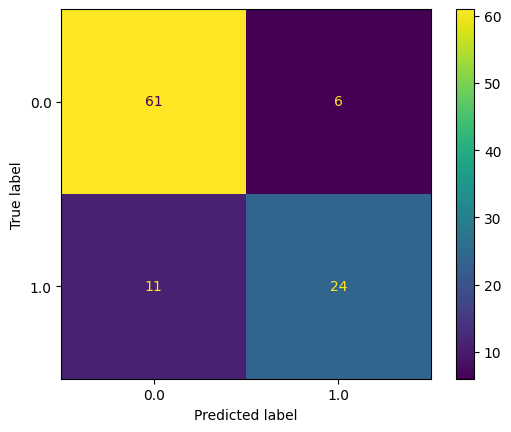

In [80]:
cm = confusion_matrix(y_val, predictions, labels=best_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(); 

## Analyse results of tuned model

### Training tweets

In [81]:
X = np.concatenate([X_train, X_val])
y = np.concatenate([y_train, y_val])

In [82]:
best_model.fit(X, y)

RandomForestClassifier(criterion='entropy', max_depth=21, min_samples_leaf=14,
                       min_samples_split=19, n_estimators=404)

In [84]:
with open("../backup/models/rf-tweet-clf.pkl", "wb") as f: 
    pkl.dump(best_model, f)

In [85]:
preds = best_model.predict(X)

In [89]:
tweets = df_annotated["text"][annotated_idxs].to_list()
n_tweets = len(tweets)

In [96]:
ix = np.random.randint(low=0, high=n_tweets)

tweet = tweets[ix]
print(tweet) 
print(f"On topic={preds[ix]}")

 FICHE ÉDUCATIVE N° 

 Taux d'inflation : Définition et calcul 
 https://centralcharts.com/fr/gm/1-apprendre/9-economie/34-analyse-fondamentale/606-taux-d-inflation-definition-et-calcul…

 Guide Économie -> Macroéconomie
 #Formation #Economie #Macroéconomie #Inflation
centralcharts.com
Taux d'inflation : Définition et calcul
Définition du taux d'inflation. Comment le calculer sur une période donnée? Les différentes méthodes de calcul pour mesurer l'évolution des prix.
1
On topic=1.0


### Test tweets

In [98]:
tweets_test = np.delete(
    df_annotated["text"].values, 
    annotated_idxs
).tolist()

In [101]:
preds_test = best_model.predict(X_test)

In [102]:
n_tweets = len(tweets_test)

In [116]:
ix = np.random.randint(low=0, high=n_tweets)

print(tweets_test[ix])
print(f"On topic: {preds_test[ix]}")

#Bitcoin (#BTC) : une protection contre les anticipations d’#inflation galopante ?

Une chronique de 
@VincentGanne
 , membre de 
@AfateNews
 , pour 
@MagazineCapital
 

#Crypto 
@PascalTRICHET
 @MachinotC
 @VideoBourse_fr
 @waldata1
 @Dembik_Chris
 @DCohendeLara
capital.fr
Bitcoin (BTC) : une protection contre les anticipations d’inflation galopante ?
Malgré le regain d’aversion au risque, qui pèse actuellement sur la Bourse, le Bitcoin (BTC) a fait mieux que résister. Notre chroniqueur Vincent Ganne, stratégiste de marché, analyste technique,...
2
10
25
On topic: 1.0


In [119]:
pd.Series(preds_test).value_counts() / n_tweets

0.0    0.740774
1.0    0.259226
dtype: float64

### Add predicted labels to annotated dataset

In [127]:
df_annotated_2 = df_annotated.copy()

In [128]:
df_annotated_2.loc[
    ~df_annotated.index.isin(annotated_idxs), 
    "topic"
] = preds_test

In [132]:
n = df_annotated_2.shape[0]
df_annotated_2["topic"].value_counts() / n

0.0    0.74002
1.0    0.25998
Name: topic, dtype: float64

In [137]:
df_on_topic = df_annotated_2.loc[df_annotated_2["topic"] == 1, :].reset_index(drop=True)

In [139]:
df_on_topic.to_csv("../backup/data/df_on_topic.csv", index=False)